# OCR for Reading Expiry Date and Production Code

Name: Anthony Kevin Oktavius

Library Import

In [2]:
! sudo apt install tesseract-ocr
! pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,137 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [19]:
import cv2
import pytesseract
import os
import albumentations as A
import numpy as np
from matplotlib import pyplot as plt
from pytesseract import Output
from IPython import display
from PIL import Image

## Data Loading

Load dataset for training, validation, and testing.

In [4]:
! unzip /content/drive/MyDrive/Dataset/Test-OCR.zip
! unzip /content/drive/MyDrive/Dataset/Components-Real.zip
! unzip /content/drive/MyDrive/Dataset/Components-Synth.zip
! unzip /content/drive/MyDrive/Dataset/Date-Real.zip
! unzip /content/drive/MyDrive/Dataset/Date-Synth.zip
! unzip /content/drive/MyDrive/Dataset/Products-Real.zip
! unzip /content/drive/MyDrive/Dataset/Products-Synth.zip

Streaming output truncated to the last 5000 lines.
  inflating: Products-Synth/images/img_06861.jpg  
  inflating: Products-Synth/images/img_06862.jpg  
  inflating: Products-Synth/images/img_06863.jpg  
  inflating: Products-Synth/images/img_06864.jpg  
  inflating: Products-Synth/images/img_06865.jpg  
  inflating: Products-Synth/images/img_06866.jpg  
  inflating: Products-Synth/images/img_06867.jpg  
  inflating: Products-Synth/images/img_06868.jpg  
  inflating: Products-Synth/images/img_06869.jpg  
  inflating: Products-Synth/images/img_06870.jpg  
  inflating: Products-Synth/images/img_06871.jpg  
  inflating: Products-Synth/images/img_06872.jpg  
  inflating: Products-Synth/images/img_06873.jpg  
  inflating: Products-Synth/images/img_06874.jpg  
  inflating: Products-Synth/images/img_06875.jpg  
  inflating: Products-Synth/images/img_06876.jpg  
  inflating: Products-Synth/images/img_06877.jpg  
  inflating: Products-Synth/images/img_06878.jpg  
  inflating: Products-Synth/ima

Print the length of each of the dataset

In [51]:
BASE_PATH_DATE_REAL = "Date-Real/images"
BASE_PATH_DATE_SYNTH = "Date-Synth/images"
BASE_PATH_PRODUCT_REAL = "Products-Real/train/images"
BASE_PATH_PRODUCT_SYNTH = "Products-Synth/images"

date_real_paths = list(os.listdir(BASE_PATH_DATE_REAL))
date_synth_paths = list(os.listdir(BASE_PATH_DATE_SYNTH))

products_real_paths = list(os.listdir(BASE_PATH_PRODUCT_REAL))
products_synth_paths = list(os.listdir(BASE_PATH_PRODUCT_SYNTH))

print(f"Number of date real dataset: {len(date_real_paths)}")
print(f"Number of date synth dataset: {len(date_synth_paths)}")
print(f"Number of products real dataset: {len(products_real_paths)}")
print(f"Number of products synth dataset: {len(products_synth_paths)}")

Number of date real dataset: 510
Number of date synth dataset: 128000
Number of products real dataset: 1102
Number of products synth dataset: 11860


See the example of the dataset given.

In [52]:
print("Date real: ")
print(date_real_paths[:10])

print("Products real: ")
print(products_real_paths[:10])

print("Date synth: ")
print(date_synth_paths[:10])

print("Products synth: ")
print(products_synth_paths[:10])

Date real: 
['img_00030.jpg', 'img_00138.jpg', 'img_00284.jpg', 'img_00170.jpg', 'img_00337.jpg', 'img_00098.jpg', 'img_00453.jpg', 'img_00383.jpg', 'img_00111.jpg', 'img_00314.jpg']
Products real: 
['img_00574.jpg', 'img_00932.jpg', 'img_00030.jpg', 'img_00138.jpg', 'img_00534.jpg', 'img_00880.jpg', 'img_00631.jpg', 'img_00284.jpg', 'img_00975.jpg', 'img_00939.jpg']
Date synth: 
['43187.jpg', '105130.jpg', '92136.jpg', '00244.jpg', '74669.jpg', '82783.jpg', '57117.jpg', '32349.jpg', '101516.jpg', '84968.jpg']
Products synth: 
['img_05557.jpg', 'img_06834.jpg', 'img_09425.jpg', 'img_03020.jpg', 'img_01406.jpg', 'img_10315.jpg', 'img_05197.jpg', 'img_08157.jpg', 'img_04583.jpg', 'img_11835.jpg']


## Data Preprocessing

Preprocessing the image with Albumenations.

In [74]:
train_image_transform = A.Compose([
  A.ToGray(p = 1),
  A.Rotate(limit = 5),
  A.RandomBrightnessContrast(
      p = 0.5,
      brightness_limit = 0.1,
      contrast_limit = 0.1,
  ),
], is_check_shapes = False)

val_image_transform = A.Compose([
  A.ToGray(p = 1),
], is_check_shapes = False)

Data Preprocessing Image Visualization Preview

<ipython-input-76-9044e69b599a>:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(N_ROWS, N_COLS, path_index + 1)


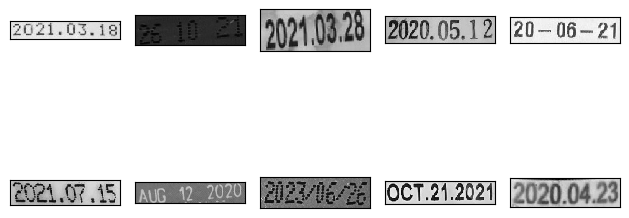

<ipython-input-76-9044e69b599a>:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(N_ROWS, N_COLS, path_index + 1)


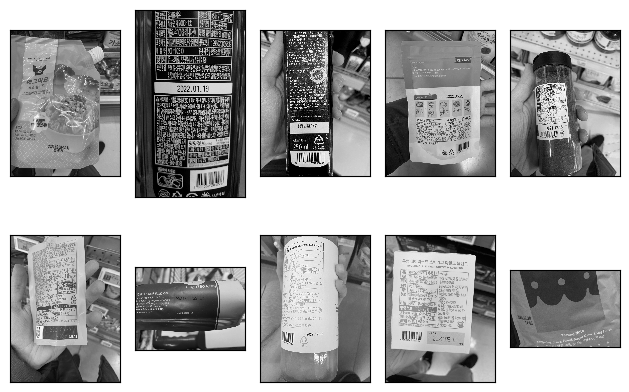

In [76]:
def disable_ticks_on_plot():
  plt.tick_params(
    axis='both',         # Apply to both axis (x and y).
    bottom = False,      # ticks along the bottom edge are off.
    top = False,         # ticks along the top edge are off.
    labelbottom = False, # labels along the bottom edge are off.
  )
  plt.xticks([])
  plt.yticks([])

def preview_preprocessed_dataset(image_path):
  image = Image.open(image_path)
  image = np.array(image)
  image = train_image_transform(image = image)['image']
  disable_ticks_on_plot()
  plt.imshow(image, interpolation='nearest')

N_ROWS = 2
N_COLS = 5

plt.title("Date Real Paths")
for path_index in range(10):
  date_real_path = date_real_paths[path_index]
  date_real_path = f"{BASE_PATH_DATE_REAL}/{date_real_path}"
  plt.subplot(N_ROWS, N_COLS, path_index + 1)
  preview_preprocessed_dataset(date_real_path)

plt.tight_layout()
plt.show()

plt.title("Product Real Paths")
for path_index in range(10):
  product_real_path = products_real_paths[path_index]
  product_real_path = f"{BASE_PATH_PRODUCT_REAL}/{product_real_path}"
  plt.subplot(N_ROWS, N_COLS, path_index + 1)
  preview_preprocessed_dataset(product_real_path)

plt.tight_layout()
plt.show()